# PŘÍPRAVA DATASETU

### Načtení potřebných knihoven

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import pathlib
import pandas as pd
from sklearn.metrics import confusion_matrix , classification_report
import itertools

### Ověření grafických procesorů

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


## Načtení dat do potřebné datové struktury

### Cesty k datasetu

In [3]:
dataset_dir = r'C:\Users\HP\Documents\GIT-BP\Screw_ds(50,30,20)'

train_dir = dataset_dir + '\\train'
valid_dir = dataset_dir + '\\valid'
test_dir  = dataset_dir + '\\test'

### Vytvoření datové struktury

In [4]:
labels='inferred'
    #Either "inferred" (labels are generated from the directory structure),or a list/tuple of integer labels of the same size as the number of image files found in the directory.
    #Labels should be sorted according to the alphanumeric order of the image file paths (obtained via os.walk(directory) in Python).

label_mode='categorical'
    #'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
    #'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).
    #'binary' means that the labels (there can be only 2) are encoded as float32 scalars with values 0 or 1 (e.g. for binary_crossentropy).

color_mode='rgb'
    #One of "grayscale", "rgb", "rgba".
    #Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.

image_size=(256, 256)
    #Size to resize images to after they are read from disk.
    #Defaults to (256, 256). Since the pipeline processes batches of images that must all have the same size, this must be provided.

batch_size= 16
    #Size of the batches of data. Default: 32.

shuffle=True
    #Whether to shuffle the data. Default: True. If set to False, sorts the data in alphanumeric order.

seed=3
    #Optional random seed for shuffling and transformations.


train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    labels=labels,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=image_size,
    shuffle=shuffle,
    seed=seed,
)

valid_ds=tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels=labels,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=image_size,
    shuffle=shuffle,
    seed=seed
)

test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels=labels,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=image_size,
    shuffle=shuffle,
    seed=seed
)

class_names = test_ds.class_names
print(class_names)

Found 238 files belonging to 6 classes.
Found 141 files belonging to 6 classes.
Found 101 files belonging to 6 classes.
['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']


## Augmentace dat

In [5]:
data_augmentation = tf.keras.Sequential([preprocessing.RandomFlip('horizontal')])

### Vizualizace datasetu

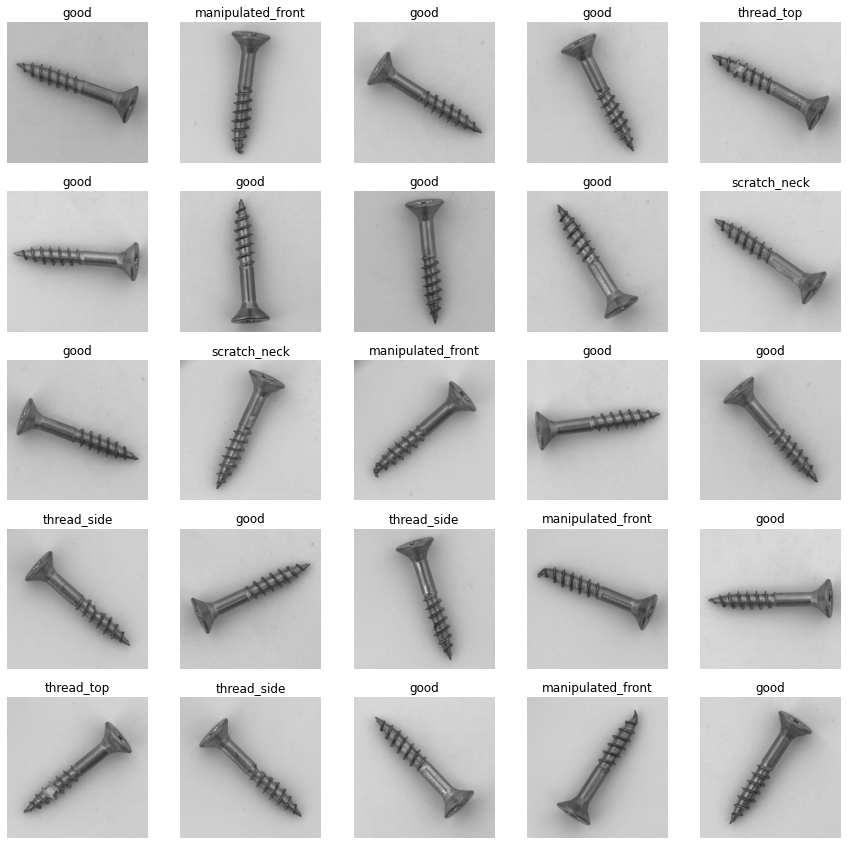

In [6]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")

## Data pipeline

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = (
    train_ds
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
test_ds = (
    test_ds
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
valid_ds = (
    valid_ds
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 6)


## Konvoluční neuronová síť

#### Předání velikoti obrázků dalším funkcím

In [9]:
a,b = image_size
input_shape = (a,b,3)
print(input_shape)

(256, 256, 3)


In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

### Tvorba modelu

In [11]:
def cnn_model():
    model = tf.keras.Sequential()
    model.add(data_augmentation)
    model.add(tf.keras.layers.Conv2D(8, (5,5),
                                     activation = 'relu'))
    
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3),
                                     activation = 'relu'))
    
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(128, (2,2),
                                     activation = 'relu'))
    
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(64,
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(32,
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(6,
                                    activation='softmax'))
    return model

In [12]:
model1 =  cnn_model()

### Konfigurace modelu pro trénování

In [13]:
optimizer =tf.keras.optimizers.Adam(
    learning_rate=1e-4)

In [14]:
model1.compile(optimizer = optimizer,
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

### Early stopping

In [15]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         min_delta=0.001,
                                         patience=50,
                                         verbose=1,
                                         mode='min',
                                         restore_best_weights=True)

## Trénování modelu

In [16]:
history = model1.fit(train_ds,
                     validation_data = valid_ds,
                     epochs=400,
                     verbose = 1,
                     callbacks=early_stopping)

Epoch 1/400
8/8 [==============================] - 5s 234ms/step - loss: 1.3798 - accuracy: 0.5504 - val_loss: 1.0776 - val_accuracy: 0.7660
Epoch 2/400
8/8 [==============================] - 1s 85ms/step - loss: 1.0831 - accuracy: 0.7563 - val_loss: 1.0108 - val_accuracy: 0.7660
Epoch 3/400
8/8 [==============================] - 1s 84ms/step - loss: 1.0252 - accuracy: 0.7563 - val_loss: 1.0092 - val_accuracy: 0.7660
Epoch 4/400
8/8 [==============================] - 1s 84ms/step - loss: 1.0236 - accuracy: 0.7563 - val_loss: 0.9923 - val_accuracy: 0.7660
Epoch 5/400
8/8 [==============================] - 1s 85ms/step - loss: 1.0096 - accuracy: 0.7563 - val_loss: 0.9851 - val_accuracy: 0.7660
Epoch 6/400
8/8 [==============================] - 1s 84ms/step - loss: 1.0037 - accuracy: 0.7563 - val_loss: 0.9838 - val_accuracy: 0.7660
Epoch 7/400
8/8 [==============================] - 1s 83ms/step - loss: 1.0001 - accuracy: 0.7563 - val_loss: 0.9781 - val_accuracy: 0.7660
Epoch 8/400
8/8 [==

In [17]:
model1.summary(
    line_length=120,
    positions=[.33, .55, .67, 1.])

Model: "sequential_1"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       
 sequential (Sequential)               (None, 256, 256, 3)        0             
                                                                                                                        
 conv2d (Conv2D)                       (None, 252, 252, 8)        608           
                                                                                                                        
 max_pooling2d (MaxPooling2D)          (None, 126, 126, 8)        0             
                                                                                                                        
 conv2d_1 (Conv2D)                     (None, 124, 124, 64)       4672          
                                                                                         

## Vlastnosti modelu

### Uložení modelu

In [18]:
model_to_save = r"C:\Users\HP\Documents\GIT-BP\models\CNN0"
model1.save(filepath=model_to_save , save_format='h5')

## Vizualizace přesnosti a ztráty naučeného modelu

In [19]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [20]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(16,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'b-', label = "Na trénovacích datech")
    plt.plot(history.history['val_accuracy'], 'r-', label = "Na validačních datech")
    plt.ylabel("Správnost",fontsize=15)
    plt.xlabel("Iterace",fontsize=15)
    plt.legend(fontsize=15)

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'b-', label = "Na trénovacích datech")
    plt.plot(history.history['val_loss'], 'r-', label = "Na validačních datech")
    plt.ylabel("Ztráta",fontsize=16)
    plt.xlabel("Iterace",fontsize=16)

    plt.legend(fontsize=15)
    plt.show()
    
history_frame = pd.DataFrame(history.history)

       loss  accuracy  val_loss  val_accuracy
0  1.379789  0.550420  1.077604      0.765957
1  1.083106  0.756303  1.010764      0.765957
2  1.025171  0.756303  1.009165      0.765957
3  1.023551  0.756303  0.992341      0.765957
4  1.009552  0.756303  0.985059      0.765957


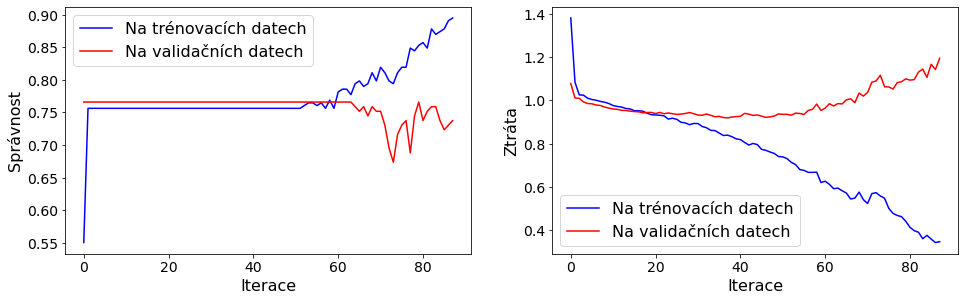

In [21]:
print(history_frame.head())
plot_accuracy_loss(history)

In [22]:
test_loss, test_acc = model1.evaluate(test_ds)
print(str(test_acc*100) + '%')

4/4 [==============================] - 0s 64ms/step - loss: 1.0596 - accuracy: 0.7228
72.27723002433777%


## Matice záměn (Confusion matrix)

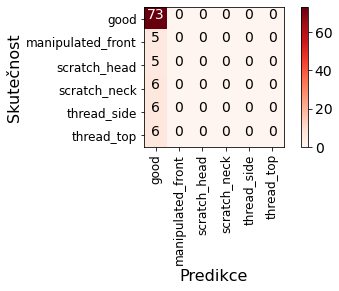

In [23]:
# Predikované rozdělení obrázků do tříd
image_predict = model1.predict(test_ds)
#print(image_predict)
image_predict = np.argmax(image_predict, axis=1)

# Skutečné rozdělení obrázků
image_true = tf.concat([y for x, y in test_ds], axis=0)
image_true = np.argmax(image_true, axis=1)

cm = confusion_matrix(y_true=image_true, y_pred=image_predict)


def plot_confusion_matrix(cm, classes,cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Skutečnost',fontsize=16)
    plt.xlabel('Predikce',fontsize=16)
    
    
plot_confusion_matrix(cm=cm, classes=class_names)

In [24]:
print(classification_report(image_true, image_predict, target_names=class_names))

                   precision    recall  f1-score   support

             good       0.72      1.00      0.84        73
manipulated_front       0.00      0.00      0.00         5
     scratch_head       0.00      0.00      0.00         5
     scratch_neck       0.00      0.00      0.00         6
      thread_side       0.00      0.00      0.00         6
       thread_top       0.00      0.00      0.00         6

         accuracy                           0.72       101
        macro avg       0.12      0.17      0.14       101
     weighted avg       0.52      0.72      0.61       101



C:\Users\HP\miniconda3\envs\spyder-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\spyder-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\spyder-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
